Matplotlib is building the font cache; this may take a moment.
e:\Portfolio\Market Basket Analysis\venv\Lib\site-packages\mlxtend\frequent_patterns\association_rules.py:186: RuntimeWarning: invalid value encountered in divide
  cert_metric = np.where(certainty_denom == 0, 0, certainty_num / certainty_denom)



Market Basket Analysis Report
Generated on: 2025-02-19 19:23:52

1. Dataset Overview
------------------
Total Transactions: 4
Unique Customers: 4
Unique Products: 3
Average Basket Size: 2.25 items

2. Association Rules Summary
--------------------------
Total Rules Generated: 12
Top 5 Rules by Lift:
     antecedents   consequents  confidence      lift
0        (bread)        (eggs)    0.666667  1.333333
1         (eggs)       (bread)    1.000000  1.333333
6  (bread, milk)        (eggs)    0.666667  1.333333
8   (milk, eggs)       (bread)    1.000000  1.333333
9        (bread)  (milk, eggs)    0.666667  1.333333

3. Key Recommendations
---------------------
- Consider bundling bread with eggs (Confidence: 66.67%, Lift: 1.33)
- Consider bundling eggs with bread (Confidence: 100.00%, Lift: 1.33)
- Consider bundling bread with eggs (Confidence: 66.67%, Lift: 1.33)



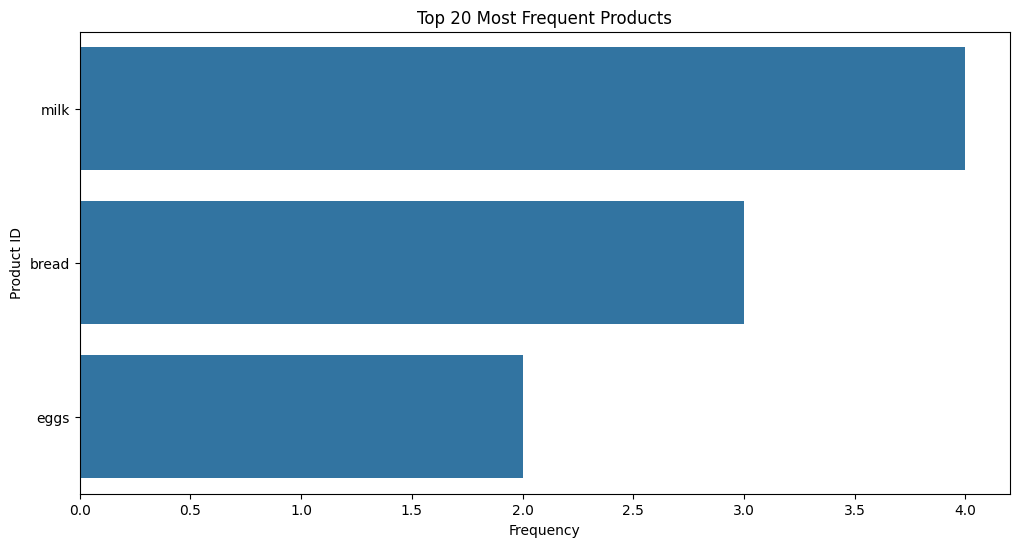

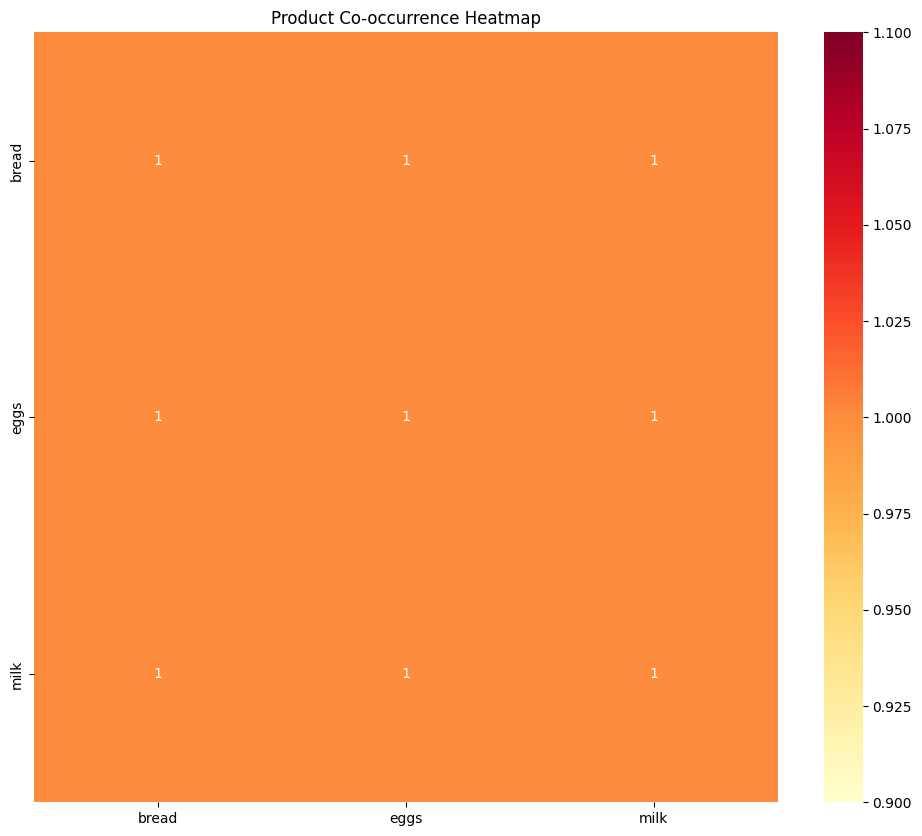

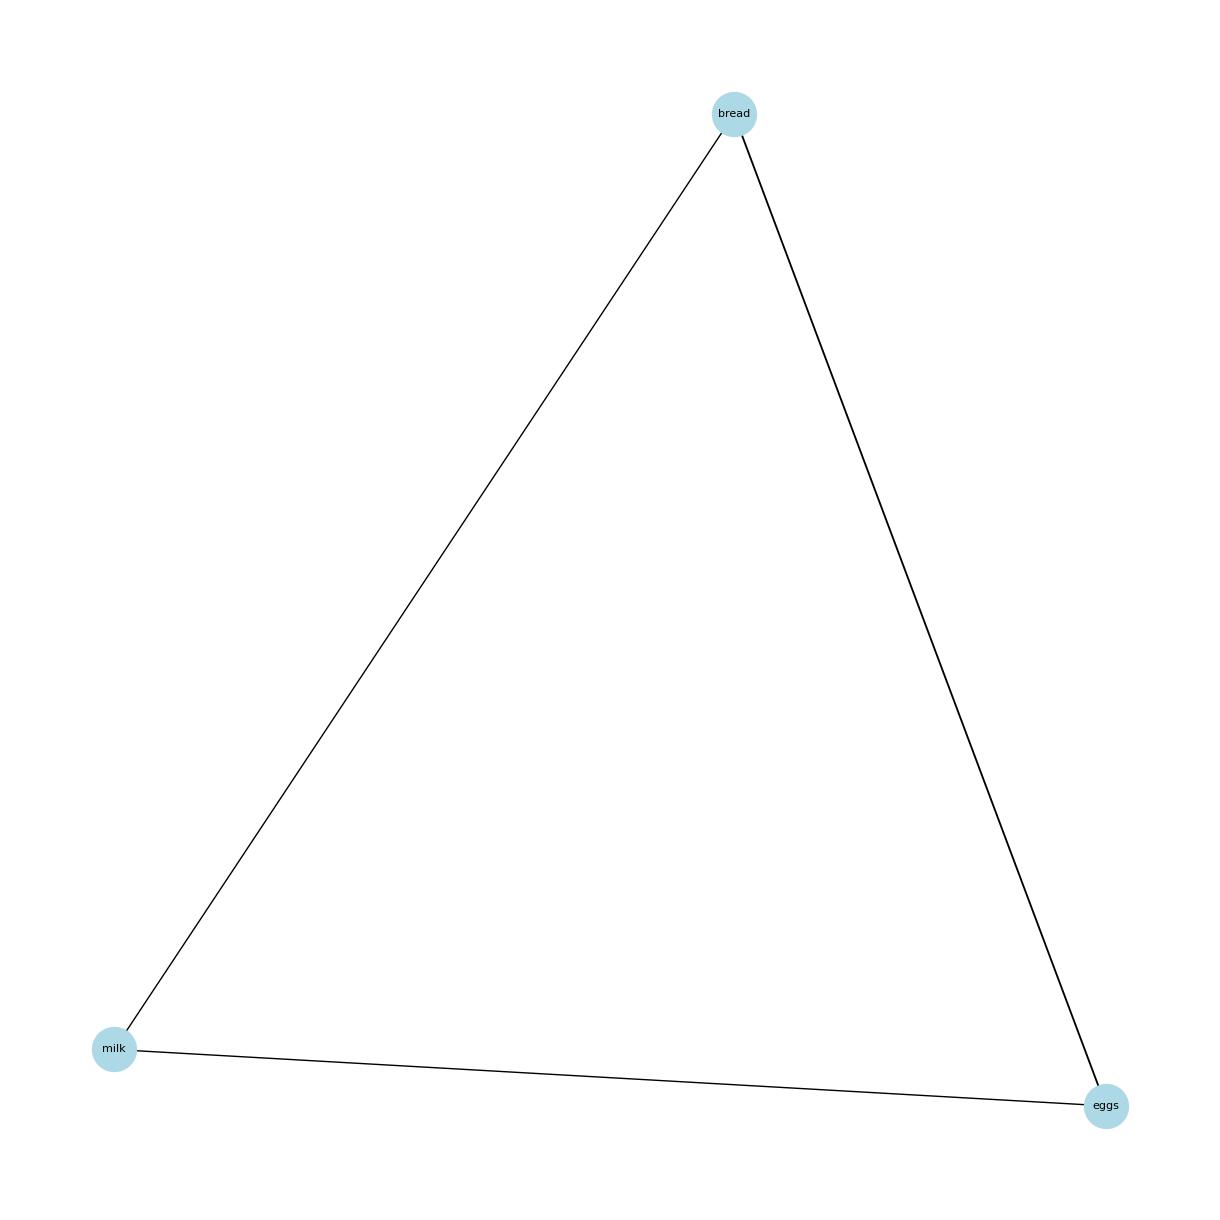

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import networkx as nx
from datetime import datetime

class MarketBasketAnalyzer:
    def __init__(self, transactions_df):
        """
        Initialize the analyzer with a DataFrame containing transaction data.
        Expected columns: transaction_id, product_id, customer_id, timestamp
        """
        self.transactions_df = transactions_df
        self.binary_matrix = None
        self.frequent_itemsets = None
        self.rules = None
        
    def preprocess_data(self):
        """Clean and preprocess the transaction data"""
        # Remove duplicates
        self.transactions_df = self.transactions_df.drop_duplicates()
        
        # Handle missing values
        self.transactions_df = self.transactions_df.dropna()
        
        # Convert timestamp if needed
        if 'timestamp' in self.transactions_df.columns:
            self.transactions_df['timestamp'] = pd.to_datetime(self.transactions_df['timestamp'])
            
    def generate_insights(self):
        """Generate basic statistics and insights about the dataset"""
        insights = {
            'unique_customers': self.transactions_df['customer_id'].nunique(),
            'unique_products': self.transactions_df['product_id'].nunique(),
            'total_transactions': self.transactions_df['transaction_id'].nunique(),
            'avg_basket_size': self.transactions_df.groupby('transaction_id')['product_id'].count().mean(),
            'date_range': (
                self.transactions_df['timestamp'].min(),
                self.transactions_df['timestamp'].max()
            ) if 'timestamp' in self.transactions_df.columns else None
        }
        return insights
    
    def create_binary_matrix(self):
        """Convert transactions into a binary matrix format"""
        # Group products by transaction
        transactions_grouped = self.transactions_df.groupby('transaction_id')['product_id'].agg(list)
        
        # Create transaction encoder
        te = TransactionEncoder()
        te_ary = te.fit(transactions_grouped).transform(transactions_grouped)
        
        # Convert to DataFrame
        self.binary_matrix = pd.DataFrame(te_ary, columns=te.columns_)
        return self.binary_matrix
    
    def find_frequent_itemsets(self, min_support=0.01):
        """Apply Apriori algorithm to find frequent itemsets"""
        if self.binary_matrix is None:
            self.create_binary_matrix()
            
        self.frequent_itemsets = apriori(
            self.binary_matrix,
            min_support=min_support,
            use_colnames=True
        )
        return self.frequent_itemsets
    
    def generate_rules(self, min_confidence=0.5):
        """Generate association rules from frequent itemsets"""
        if self.frequent_itemsets is None:
            raise ValueError("Must find frequent itemsets before generating rules")
            
        self.rules = association_rules(
            self.frequent_itemsets,
            metric="confidence",
            min_threshold=min_confidence
        )
        return self.rules
    
    def plot_product_frequency(self, top_n=20):
        """Plot top N most frequent products"""
        plt.figure(figsize=(12, 6))
        product_freq = self.transactions_df['product_id'].value_counts().head(top_n)
        sns.barplot(x=product_freq.values, y=product_freq.index)
        plt.title(f'Top {top_n} Most Frequent Products')
        plt.xlabel('Frequency')
        plt.ylabel('Product ID')
        return plt
    
    def plot_association_heatmap(self, top_n=20):
        """Create a heatmap of product co-occurrences"""
        if self.binary_matrix is None:
            self.create_binary_matrix()
            
        # Calculate co-occurrence matrix
        cooc_matrix = self.binary_matrix.T.dot(self.binary_matrix)
        
        # Plot heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(
            cooc_matrix.iloc[:top_n, :top_n],
            annot=True,
            cmap='YlOrRd',
            fmt='g'
        )
        plt.title('Product Co-occurrence Heatmap')
        return plt
    
    def create_network_graph(self, min_confidence=0.5, min_lift=1.0):
        """Create a network graph of product associations"""
        if self.rules is None:
            self.generate_rules(min_confidence)
            
        # Create network graph
        G = nx.Graph()
        
        # Add edges for rules meeting criteria
        for _, rule in self.rules[
            (self.rules['confidence'] >= min_confidence) &
            (self.rules['lift'] >= min_lift)
        ].iterrows():
            antecedents = list(rule['antecedents'])[0]
            consequents = list(rule['consequents'])[0]
            G.add_edge(
                antecedents,
                consequents,
                weight=rule['lift'],
                confidence=rule['confidence']
            )
            
        # Draw the graph
        plt.figure(figsize=(12, 12))
        pos = nx.spring_layout(G)
        nx.draw(
            G,
            pos,
            with_labels=True,
            node_color='lightblue',
            node_size=1000,
            font_size=8,
            width=[G[u][v]['weight'] for u, v in G.edges()]
        )
        return plt
    
    def generate_report(self):
        """Generate a comprehensive analysis report"""
        insights = self.generate_insights()
        
        report = f"""
Market Basket Analysis Report
Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}

1. Dataset Overview
------------------
Total Transactions: {insights['total_transactions']:,}
Unique Customers: {insights['unique_customers']:,}
Unique Products: {insights['unique_products']:,}
Average Basket Size: {insights['avg_basket_size']:.2f} items

2. Association Rules Summary
--------------------------
Total Rules Generated: {len(self.rules) if self.rules is not None else 0}
Top 5 Rules by Lift:
{self.rules.nlargest(5, 'lift')[['antecedents', 'consequents', 'confidence', 'lift']].to_string()}

3. Key Recommendations
---------------------
"""
        # Add recommendations based on rules
        if self.rules is not None:
            top_rules = self.rules.nlargest(3, 'lift')
            for _, rule in top_rules.iterrows():
                report += f"- Consider bundling {list(rule['antecedents'])[0]} with {list(rule['consequents'])[0]} "
                report += f"(Confidence: {rule['confidence']:.2%}, Lift: {rule['lift']:.2f})\n"
        
        return report

# Example usage function
def demonstrate_usage():
    # Create sample data
    data = {
        'transaction_id': [1, 1, 1, 2, 2, 3, 3, 3, 4],
        'product_id': ['bread', 'milk', 'eggs', 'bread', 'milk', 'milk', 'eggs', 'bread', 'milk'],
        'customer_id': [101, 101, 101, 102, 102, 103, 103, 103, 104],
        'timestamp': ['2024-02-18 10:00:00'] * 9
    }
    df = pd.DataFrame(data)
    
    # Initialize analyzer
    analyzer = MarketBasketAnalyzer(df)
    
    # Run analysis
    analyzer.preprocess_data()
    analyzer.create_binary_matrix()
    analyzer.find_frequent_itemsets(min_support=0.2)
    analyzer.generate_rules(min_confidence=0.5)
    
    # Generate visualizations
    analyzer.plot_product_frequency()
    analyzer.plot_association_heatmap()
    analyzer.create_network_graph()
    
    # Generate report
    print(analyzer.generate_report())

if __name__ == "__main__":
    demonstrate_usage()